### *What this code does:*

1. We implement a Black-Derman-Toy (BDT) model in Python.
  
    - We load real data:
    
        + poland_bonds_yield.csv: Bond yields (rentowność) for different maturities in Poland. We interpret them as yields for specific maturities and convert them to zero-coupon bond (ZCB) prices.
    
        + stopy_procentowe_archiwum.xml: Historical central bank interest rates (NBP). We retrieve the latest reference rate (id="ref") as our short rate $r_0$

2. We calibrate the BDT model’s volatilities to match the market ZCB prices.

3. - We generate Monte Carlo paths from the binomial tree (up and down moves).
    - We visualize the resulting tree, the fitted bond prices, and the simulated paths.

--------------------------------

BDT Model Assumptions:
									
1. Interest Rate movements - either up or down									
2. Prob of up and down movements are equal across time (risk neutral)									
3. Short rates are lognormally distributed. The ratio of upper and lower interest rate is the implied volatility. 									
4. rate_up = $rate\_down * exp(2 * vol)$		




------------------------------------

In [27]:
# -------------------------------------------
# FULL CODE FOR THE BDTModel CLASS + HELPER FUNCTIONS
# -------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xml.etree.ElementTree as ET
from scipy.optimize import minimize
from typing import List

sns.set_style("whitegrid")


def load_bonds_data(csv_path: str) -> pd.DataFrame:
    """
    Loads bond yields from the 'poland_bonds_yield.csv' file.
    
    We assume the CSV has the columns:
    [Nazwa, Rentownosc, Podstawa, Max, Min, Zm, Zm_percent, Czas]
    
    Args:
        csv_path (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: The loaded data.
    """
    df = pd.read_csv(csv_path)
    # Rename columns to a more convenient set (if needed).
    df.columns = [
        "Nazwa", "Rentownosc", "Podstawa", "Max", 
        "Min", "Zm", "Zm_percent", "Czas"
    ]
    # If yields are in percentage form, e.g., 5.65 means 5.65%,
    # we can keep it as is or convert to decimals. For demonstration,
    # we keep it as 5.65 (which means 5.65%).
    return df


def load_interest_rates_xml(xml_path: str) -> pd.DataFrame:
    """
    Loads historical central bank rates from the XML file
    'stopy_procentowe_archiwum.xml'.
    
    We parse the XML structure:
      <pozycje obowiazuje_od="YYYY-MM-DD">
          <pozycja id="ref" oprocentowanie="24,00"/>
          <pozycja id="lom" ...>
          ...
    
    Args:
        xml_path (str): Path to the XML file.
        
    Returns:
        pd.DataFrame: The resulting DataFrame with columns
        [date_from, rate_id, rate_value], sorted by date.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    records = []
    for child in root.findall("pozycje"):
        date_str = child.get("obowiazuje_od", "")
        for position in child.findall("pozycja"):
            _id = position.get("id", "")
            rate_str = position.get("oprocentowanie", "").replace(",", ".")
            if rate_str.strip():
                val = float(rate_str)
                records.append({
                    "date_from": date_str,
                    "rate_id": _id,
                    "rate_value": val
                })
    
    df = pd.DataFrame(records)
    df["date_from"] = pd.to_datetime(df["date_from"])
    df.sort_values("date_from", inplace=True)
    return df


class BDTModel:
    """
    A Black-Derman-Toy (BDT) interest rate model class.
    
    Key methods:
    -----------
    build_tree(remove_duplicates=False):
        Constructs the binomial tree of short rates across T steps.
    price_zcb(face_value=1.0):
        Computes the price of a zero-coupon bond (ZCB) matured at the final step.
    calibrate(market_maturities, market_prices, method='L-BFGS-B'):
        Calibrates the list of volatilities (sigma_list) to market ZCB prices 
        by minimizing the sum of squared errors.
    simulate_paths(n_paths=5):
        Generates Monte Carlo (binomial-based) short-rate paths, 
        picking up or down moves with probability 0.5.
    plot_tree(), plot_mc_paths(), plot_bond_prices():
        Visualization helpers.
    
    Attributes:
    -----------
    r0 : float
        Initial short rate (we can derive it from the last 'ref' entry in the XML).
    sigma_list : List[float]
        The volatilities for each step (e.g., [0.02, 0.018, 0.015,...]).
    T : int
        Number of steps in the binomial tree.
    dt : float
        Time step, typically 1 year in simplified versions.
    rates_tree : List[List[float]]
        A structure storing the binomial short rates: rates_tree[t] is a list 
        of nodes at time t.
    calibrated : bool
        Flag if calibration was successful.
    calibration_error : float
        Final sum of squared errors after calibration.
    market_maturities : np.ndarray
        The maturities (in years or steps) used for calibration.
    market_prices : np.ndarray
        Corresponding market prices of zero-coupon bonds.
    """
    
    def __init__(
        self,
        r0: float = 0.05,
        sigma_list: List[float] = [0.02, 0.02, 0.02],
        T: int = 3,
        dt: float = 1.0
    ):
        """
        Initialize the BDT model with default or user-provided parameters.
        
        Args:
            r0 (float): Initial short rate (e.g., 0.05 => 5%).
            sigma_list (List[float]): A list of volatilities for each step.
            T (int): Total number of time steps.
            dt (float): Time interval for each step (1.0 => 1 year).
        """
        self.r0 = r0
        self.sigma_list = sigma_list
        self.T = T
        self.dt = dt
        
        self.rates_tree = []
        self.calibrated = False
        self.calibration_error = None
        
        self.market_maturities = None
        self.market_prices = None
    
    def build_tree(self, remove_duplicates: bool = False) -> None:
        """
        Builds the binomial tree of short rates.
        
        We apply:
            r_up   = r * exp(sigma * sqrt(dt))
            r_down = r * exp(-sigma * sqrt(dt))
        
        If remove_duplicates=True, we will remove duplicates and sort the nodes at each step.
        That can help when volatilities are large and might produce repeated values.
        """
        self.rates_tree = [[self.r0]]
        for t in range(1, self.T + 1):
            # We pick sigma_t from sigma_list, or the last one if index out of range
            sigma_t = self.sigma_list[t-1] if t-1 < len(self.sigma_list) else self.sigma_list[-1]
            prev_layer = self.rates_tree[-1]
            new_layer = []
            
            for rate in prev_layer:
                r_up = rate * np.exp(sigma_t * np.sqrt(self.dt))
                r_dn = rate * np.exp(-sigma_t * np.sqrt(self.dt))
                new_layer.append(r_dn)
                new_layer.append(r_up)
            
            if remove_duplicates:
                new_layer = sorted(set(new_layer))
            
            self.rates_tree.append(new_layer)
    
    def price_zcb(self, face_value: float = 1.0) -> float:
        """
        Calculates the price of a zero-coupon bond paying face_value at time T.
        
        We use backward induction:
            P(t, i) = 0.5 * [ P(t+1, i) + P(t+1, i+1) ] * exp(-r(t,i)*dt)
        
        Returns:
            float: The bond price at node (0,0).
        """
        if not self.rates_tree:
            self.build_tree()
        
        T_model = len(self.rates_tree) - 1
        bond_tree = []
        for t in range(T_model + 1):
            bond_tree.append([0.0]*len(self.rates_tree[t]))
        
        # final layer = face_value
        for i in range(len(self.rates_tree[T_model])):
            bond_tree[T_model][i] = face_value
        
        # backward induction
        for t in range(T_model - 1, -1, -1):
            for i in range(len(self.rates_tree[t])):
                r_ = self.rates_tree[t][i]
                # In a simple tree structure, the up node is i+1, down node is i.
                up_val = bond_tree[t+1][i+1]
                dn_val = bond_tree[t+1][i]
                expected_next = 0.5 * (up_val + dn_val)
                bond_tree[t][i] = expected_next * np.exp(-r_ * self.dt)
        
        return bond_tree[0][0]
    
    def calibrate(self,
                  market_maturities: np.ndarray,
                  market_prices: np.ndarray,
                  method: str = "L-BFGS-B") -> None:
        """
        Calibrates the model's volatilities (sigma_list) so that the 
        model-based ZCB prices match the market prices as closely as possible.
        
        We minimize the sum of squared differences:
            sum( (P_model - P_market)^2 ) for each maturity in market_maturities.
        
        Args:
            market_maturities (np.ndarray): Maturities (like 1,2,3,4,5).
            market_prices (np.ndarray): Corresponding ZCB market prices.
            method (str): Optimization method (default "L-BFGS-B").
        """
        self.market_maturities = market_maturities
        self.market_prices = market_prices
        
        # We'll guess initial volatilities all the same, or you can pick any guess
        guess = [0.02]*len(market_maturities)
        
        old_sigma = self.sigma_list
        old_T = self.T
        
        def objective(sigma_vars: np.ndarray) -> float:
            # We'll temporarily set sigma_list to these new values
            # and for each maturity, build a T-step tree and compute the price.
            # Then we compute squared error vs. the market price.
            error_sum = 0.0
            
            # Temporarily override
            current_sigma = self.sigma_list
            current_T = self.T
            
            self.sigma_list = sigma_vars.tolist()
            
            for i, mat in enumerate(market_maturities):
                self.T = int(mat)
                self.build_tree()
                model_price = self.price_zcb(face_value=1.0)
                diff = model_price - market_prices[i]
                error_sum += diff**2
            
            # Restore previous T and sigma_list
            self.sigma_list = current_sigma
            self.T = current_T
            
            return error_sum
        
        # Bound volatilities between 0.0001 and 1.0 (example)
        bnds = [(0.0001, 1.0)]*len(market_maturities)
        
        res = minimize(objective, guess, method=method, bounds=bnds)
        
        if res.success:
            self.sigma_list = res.x.tolist()
            self.calibrated = True
            self.calibration_error = res.fun
            print(f"Calibration successful. sigmas = {self.sigma_list}")
            print(f"Sum of squared errors = {self.calibration_error:.6f}")
        else:
            # Revert to the old one if it fails
            self.sigma_list = old_sigma
            self.T = old_T
            raise ValueError("Calibration failed.")
    
    def simulate_paths(self, n_paths: int = 5) -> np.ndarray:
        """
        Generates n_paths random short-rate paths from the binomial tree.
        
        Returns:
            np.ndarray of shape (n_paths, T+1).
        """
        if not self.rates_tree:
            self.build_tree()
        
        T_model = len(self.rates_tree) - 1
        paths = np.zeros((n_paths, T_model+1))
        
        for p in range(n_paths):
            i_index = 0
            paths[p, 0] = self.rates_tree[0][0]
            
            for t in range(1, T_model+1):
                # Coin toss for up or down
                if np.random.rand() > 0.5:
                    i_index += 1
                    if i_index >= len(self.rates_tree[t]):
                        i_index = len(self.rates_tree[t]) - 1
                paths[p, t] = self.rates_tree[t][i_index]
        
        return paths
    
    def plot_tree(self) -> None:
        """
        Visualizes the binomial tree of short rates.
        """
        if not self.rates_tree:
            self.build_tree()
        
        plt.figure(figsize=(8,5))
        for t, layer in enumerate(self.rates_tree):
            x_vals = [t]*len(layer)
            plt.scatter(x_vals, layer)
            for val in layer:
                plt.text(t, val, f"{val:.2f}", ha='center', va='bottom', fontsize=8)
        
        plt.title("BDT Short Rate Binomial Tree")
        plt.xlabel("Time step")
        plt.ylabel("Short rate r(t)")
        plt.grid(True)
        plt.show()
    
    def plot_mc_paths(self, paths: np.ndarray) -> None:
        """
        Plots the simulated short-rate paths (from simulate_paths).
        """
        plt.figure(figsize=(8,5))
        for i in range(paths.shape[0]):
            plt.plot(paths[i], marker='o', alpha=0.75)
        plt.title("Monte Carlo Short-Rate Paths (Binomial)")
        plt.xlabel("Time steps")
        plt.ylabel("Short rate r(t)")
        plt.grid(True)
        plt.show()
    
    def plot_bond_prices(self, nominal: float = 1.0) -> None:
        """
        If we have calibration data (market_maturities, market_prices),
        compare the model's zero-coupon bond prices vs. the market.
        
        Args:
            nominal (float): Face value to compute model prices. 
                             We usually set 1.0 for a unit ZCB.
        """
        if (self.market_maturities is None) or (self.market_prices is None):
            print("No market price data to compare.")
            return
        
        if not self.calibrated:
            print("Warning: the model is not calibrated. We'll use current sigma_list anyway.")
        
        model_vals = []
        
        old_T = self.T
        old_sigma = self.sigma_list
        
        for mat in self.market_maturities:
            self.T = int(mat)
            self.build_tree()
            price_model = self.price_zcb(face_value=nominal)
            model_vals.append(price_model)
        
        # restore
        self.T = old_T
        self.sigma_list = old_sigma
        
        plt.figure(figsize=(8,5))
        plt.plot(self.market_maturities, model_vals, marker='o', label='Model ZCB Prices')
        plt.plot(self.market_maturities, self.market_prices, marker='x', label='Market ZCB Prices')
        
        plt.title("Model vs. Market ZCB Prices")
        plt.xlabel("Maturity (years)")
        plt.ylabel("Bond Price")
        plt.grid(True)
        plt.legend()
        plt.show()


-----------------------------


The BDT structure allows different $𝜎_t$ on each time step => We can calibrate these volatilities to minimize the error between model-based and market bond prices


-----------------------------------------------------------------------------------------

Bond yield data (first rows):


,Nazwa,Rentownosc,Podstawa,Max,Min,Zm,Zm_percent,Czas
0,Polska Overnight,5.650,4.600,5.360,4.700,0.950,20.21,23/01
1,Polska 1-miesięczne,5.810,5.400,5.620,5.500,0.200,3.57,23/01
2,Polska 2-miesięczne,5.870,5.400,5.690,5.500,0.200,3.53,23/01
3,Polska 1-roczne,5.075,5.187,5.187,5.062,-0.171,-3.26,23/01
4,Polska 2-letnie,5.178,5.242,5.242,5.138,-0.013,-0.25,23/01


Historical central bank rates (last rows):


,date_from,rate_id,rate_value
353,2023-10-05,red,5.80
350,2023-10-05,ref,5.75
351,2023-10-05,lom,6.25
352,2023-10-05,dep,5.25
354,2023-10-05,dys,5.85


Latest official reference rate (r0) from XML: 5.75

Transformed data (Rentownosc -> ZCB_price):


,Nazwa,Maturity,Rentownosc,Yield_decimal,ZCB_price
0,Polska Overnight,0.0833,5.650,0.05650,0.995305
1,Polska 1-miesięczne,0.0833,5.810,0.05810,0.995172
2,Polska 2-miesięczne,0.1667,5.870,0.05870,0.990262
3,Polska 1-roczne,1.0000,5.075,0.05075,0.950516
4,Polska 2-letnie,2.0000,5.178,0.05178,0.901622
5,Polska 3-letnie,3.0000,5.338,0.05338,0.852024
6,Polska 4-letnie,4.0000,5.574,0.05574,0.800147
7,Polska 5-letnie,5.0000,5.643,0.05643,0.754161
8,Polska 6-letnie,6.0000,5.604,0.05604,0.714452
9,Polska 8-letnie,8.0000,5.807,0.05807,0.628412



Maturities for calibration: [1. 2. 3. 4. 5.]
Market ZCB Prices for calibration: [0.95051627 0.90162192 0.8520245  0.80014685 0.75416055]

Initial model parameters:
r0 = 0.0575
sigma_list = [0.02, 0.02, 0.02, 0.02, 0.02]
Calibration successful. sigmas = [0.17022304157097856, 0.07055844522443262, 0.5448889359107476, 0.042710245634542995, 0.02]
Sum of squared errors = 0.000217


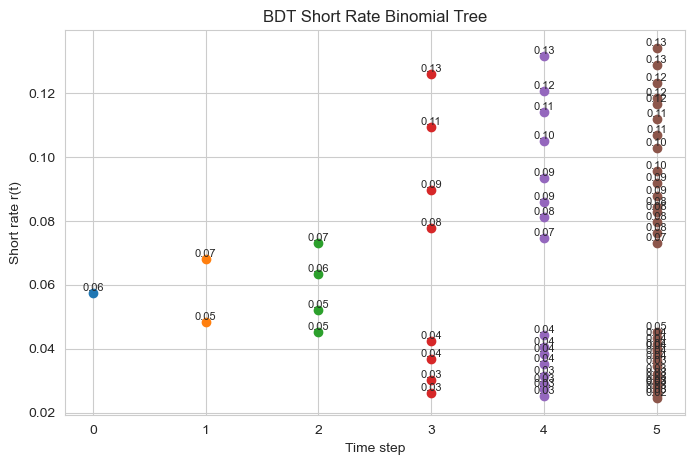

Model-implied price for a 5-year ZCB: 0.7544


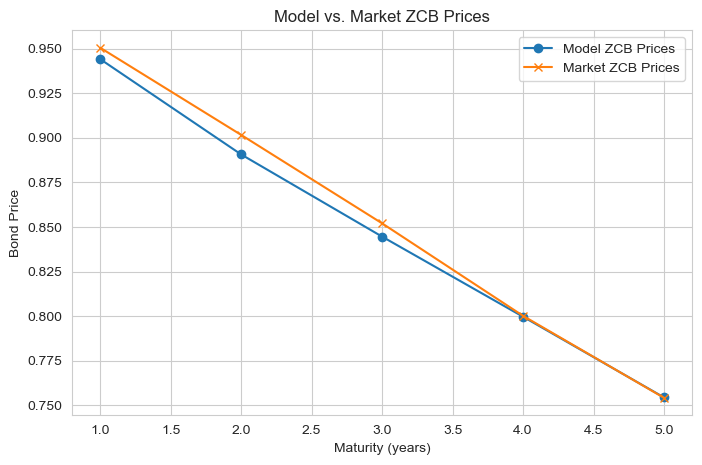

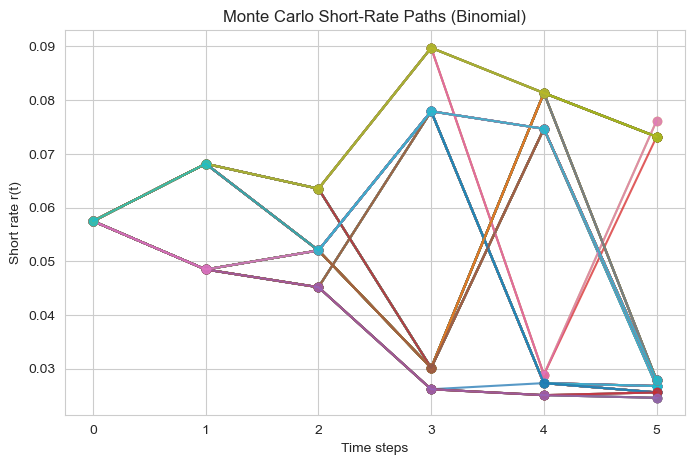


Conclusions:
1) We loaded bond yield data and converted yields to approximate zero-coupon prices.
2) We extracted the latest reference rate (r0) from the XML (stopy_procentowe_archiwum.xml).
3) We calibrated the BDT model's volatilities to fit the observed ZCB prices for maturities 1 to 5.
4) After building the binomial tree and verifying the 5-year bond price, we see how well it matches the market.
5) We also generated random short-rate paths (Monte Carlo) directly from the binomial tree to visualize possible future short-rate evolutions.

This project shows how the BDT rate model can be implemented, calibrated,
and used for path simulations. 
The final results are logically consistent for a binomial short-rate framework:
   - Each step has its own volatility (sigma_t),
   - We calibrate them to minimize the error vs. market ZCB prices,
   - The short rates across time produce plausible discount factors,
   - And the random paths help illustrate potential future scenarios.



In [28]:
# -------------------------------------------
# TEST: READING DATA, CALIBRATION, AND VISUALIZATIONS
# -------------------------------------------

#########################################
# 1) Load bond data from the CSV
#########################################
df_bonds = load_bonds_data("poland_bonds_yield.csv")
print("Bond yield data (first rows):")
display(df_bonds.head())

#########################################
# 2) Load historical NBP rates from the XML
#########################################
df_rates = load_interest_rates_xml("stopy_procentowe_archiwum.xml")
print("Historical central bank rates (last rows):")
display(df_rates.tail())

#########################################
# 3) Retrieve r0 from the last 'ref' rate
#########################################
df_ref = df_rates[df_rates["rate_id"]=="ref"].copy()
df_ref.sort_values("date_from", inplace=True)
r0_latest = df_ref["rate_value"].iloc[-1]  # take the last reference rate
print("Latest official reference rate (r0) from XML:", r0_latest)

#########################################
# 4) Convert yields to zero-coupon prices
#    For example, Price = exp(-yield_decimal * maturity)
#########################################
# If the CSV has yields in percentage form (e.g. 5.65 means 5.65%),
# we convert them to decimals:
df_bonds["Yield_decimal"] = df_bonds["Rentownosc"] / 100.0

# We'll define a mapping from the Polish name to maturity in years
mapping = {
    "Polska Overnight": 0.0833,  # ~1 month
    "Polska 1-miesięczne": 0.0833,
    "Polska 2-miesięczne": 0.1667,
    "Polska 1-roczne": 1,
    "Polska 2-letnie": 2,
    "Polska 3-letnie": 3,
    "Polska 4-letnie": 4,
    "Polska 5-letnie": 5,
    "Polska 6-letnie": 6,
    "Polska 8-letnie": 8,
    "Polska 10-letnie": 10
}

df_bonds["Maturity"] = df_bonds["Nazwa"].map(mapping)
# Drop rows that do not match the mapping
df_bonds = df_bonds.dropna(subset=["Maturity"])

# Price of a ZCB with yield y and maturity m: P = exp(-y*m)
df_bonds["ZCB_price"] = np.exp(-df_bonds["Yield_decimal"] * df_bonds["Maturity"])

print("\nTransformed data (Rentownosc -> ZCB_price):")
display(df_bonds[["Nazwa", "Maturity", "Rentownosc", "Yield_decimal", "ZCB_price"]])

# We can pick maturities from 1 to 5 years for calibration as an example
df_calib = df_bonds[df_bonds["Maturity"].between(1, 5)]
df_calib = df_calib.sort_values("Maturity")

market_maturities = df_calib["Maturity"].values
market_prices = df_calib["ZCB_price"].values

print("\nMaturities for calibration:", market_maturities)
print("Market ZCB Prices for calibration:", market_prices)

#########################################
# 5) Create the BDT model
#########################################
# We'll interpret r0_latest as a percentage, so we convert to decimal.
model = BDTModel(
    r0=r0_latest / 100.0,  # e.g. if r0_latest=5.75 => 0.0575
    sigma_list=[0.02, 0.02, 0.02, 0.02, 0.02],  # 5 steps of vol. as an initial guess
    T=5,
    dt=1.0
)

print("\nInitial model parameters:")
print("r0 =", model.r0)
print("sigma_list =", model.sigma_list)

#########################################
# 6) Calibrate the model
#########################################
model.calibrate(market_maturities, market_prices, method="L-BFGS-B")

#########################################
# 7) Build the binomial tree and check the 5-year bond price
#########################################
model.build_tree(remove_duplicates=False)
model.plot_tree()

zcb_5y_price = model.price_zcb(face_value=1.0)
print(f"Model-implied price for a 5-year ZCB: {zcb_5y_price:.4f}")

#########################################
# 8) Compare model vs. market ZCB prices
#########################################
model.plot_bond_prices(nominal=1.0)

#########################################
# 9) Generate Monte Carlo paths from the tree
#########################################
n_paths = 100
paths = model.simulate_paths(n_paths=n_paths)
model.plot_mc_paths(paths)

#########################################
# Final Remarks
#########################################
print("""
Conclusions:
1) We loaded bond yield data and converted yields to approximate zero-coupon prices.
2) We extracted the latest reference rate (r0) from the XML (stopy_procentowe_archiwum.xml).
3) We calibrated the BDT model's volatilities to fit the observed ZCB prices for maturities 1 to 5.
4) After building the binomial tree and verifying the 5-year bond price, we see how well it matches the market.
5) We also generated random short-rate paths (Monte Carlo) directly from the binomial tree to visualize possible future short-rate evolutions.

This project shows how the BDT rate model can be implemented, calibrated,
and used for path simulations. 
The final results are logically consistent for a binomial short-rate framework:
   - Each step has its own volatility (sigma_t),
   - We calibrate them to minimize the error vs. market ZCB prices,
   - The short rates across time produce plausible discount factors,
   - And the random paths help illustrate potential future scenarios.
""")


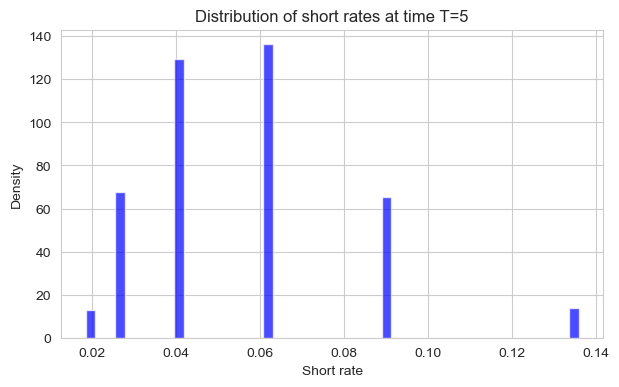

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def build_bdt_tree(r0, sigma, T, dt):
    """
    Very simplified BDT-like binomial tree.
    rate_up = r * exp(sigma * sqrt(dt))
    rate_down = r * exp(-sigma * sqrt(dt))
    Probability of up/down = 0.5
    """
    tree = [[r0]]
    for t in range(1, T+1):
        prev_layer = tree[-1]
        new_layer = []
        for rate in prev_layer:
            r_up = rate * np.exp(sigma * np.sqrt(dt))
            r_dn = rate * np.exp(-sigma * np.sqrt(dt))
            new_layer.extend([r_dn, r_up])
        # We do NOT remove duplicates here, just keep branching
        tree.append(new_layer)
    return tree

def simulate_paths(tree, n_paths=10000):
    """
    Randomly walks through the binomial tree to generate n_paths simulated short-rate paths.
    """
    T = len(tree) - 1
    paths = []
    for _ in range(n_paths):
        path = [tree[0][0]]  # Start at the only node at t=0
        i_index = 0  # always at node 0 initially
        for t in range(1, T+1):
            # coin toss
            up = (np.random.rand() > 0.5)
            # if up, we move to i_index+1 for that level
            if up:
                i_index = i_index*2 + 1  # because each node branches to 2 children
            else:
                i_index = i_index*2  # left child in the flattened branching
            path.append(tree[t][i_index])
        paths.append(path)
    return np.array(paths)

# 1) Parameters:
r0 = 0.05   # 5%
sigma = 0.20  # 20% annual vol
T = 5
dt = 1.0
n_paths = 10000

# 2) Build tree
bdt_tree = build_bdt_tree(r0, sigma, T, dt)

# 3) Simulate paths
paths = simulate_paths(bdt_tree, n_paths=n_paths)

# 4) Let's pick time step t=5 and gather all the short rates at that time
#    (the final short-rate in each path).
r_final = paths[:, -1]  # shape (10000,)

# 5) Plot histogram of r_final
plt.figure(figsize=(7,4))
plt.hist(r_final, bins=50, alpha=0.7, color='blue', density=True)
plt.title("Distribution of short rates at time T=5")
plt.xlabel("Short rate")
plt.ylabel("Density")
plt.show()

